# Advanced Certification Program in AI and MLOps
## A program by IISc and TalentSprint
### Mini-Project: Patient Survival Prediction using XGBoost

## Learning Objectives

At the end of the experiment, you will be able to:

* perform data preprocessing on the Heart failure dataset
* train an XGBoost model to predict survival of patients with heart failure
* save your trained model
* creare Gradio application
* deploy application with AWS

## Dataset Description

[Heart failure clinical records dataset](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records) contains the medical records of 299 patients who had **heart failure**, collected during their follow-up period, where each patient profile has 13 clinical features given as:

- **age**: age of the patient (years)
- **anaemia**: decrease of red blood cells or hemoglobin (boolean)
- **high_blood_pressure**: if the patient has hypertension (boolean)
- **creatinine_phosphokinase (CPK)**: level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: if the patient has diabetes (boolean)
- **ejection_fraction**: percentage of blood leaving the heart at each contraction (percentage)
- **platelets**: platelets in the blood (kiloplatelets/mL)
- **sex**: woman or man (binary)
- **serum_creatinine**: level of serum creatinine in the blood (mg/dL)
- **serum_sodium**: level of serum sodium in the blood (mEq/L)
- **smoking**: if the patient smokes or not (boolean)
- **time**: follow-up period (days)
- **DEATH_EVENT**: if the patient deceased during the follow-up period (boolean)

## Information

Cardiovascular diseases kill millions of people globally every year, and they mainly exhibit as myocardial infarctions and heart failures. Heart failure occurs when the heart cannot pump enough blood to meet the needs of the body.Available electronic medical records of patients quantify symptoms, body features, and clinical laboratory test values, which can be used to perform biostatistics analysis aimed at highlighting patterns and correlations otherwise undetectable by medical doctors. Machine learning, in particular, can predict patients' survival from their data and can individuate the most important features among those included in their medical records.

### Problem Statement

* Build a XGBoost classifier to predict survival of patients with heart failure
* Deploy the application with AWS ECR and ECS

Please refer to ***The demo session held on 26th Oct - Deployment with AWS ECR and ECS*** to get familiar with how to deploy the application with AWS.

### Install XGBoost library

In [1]:
!pip -qq install xgboost

### Import required packages

In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

In [3]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/CDS/Datasets/heart_failure_clinical_records_dataset.csv
!ls | grep '.csv'

heart_failure_clinical_records_dataset.csv


### Load the dataset

In [4]:
# Load dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
# Shape of dataset
df.shape

(299, 13)

### Check missing values

In [6]:
# Check for missing values
df.isna().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


### Handle Outliers

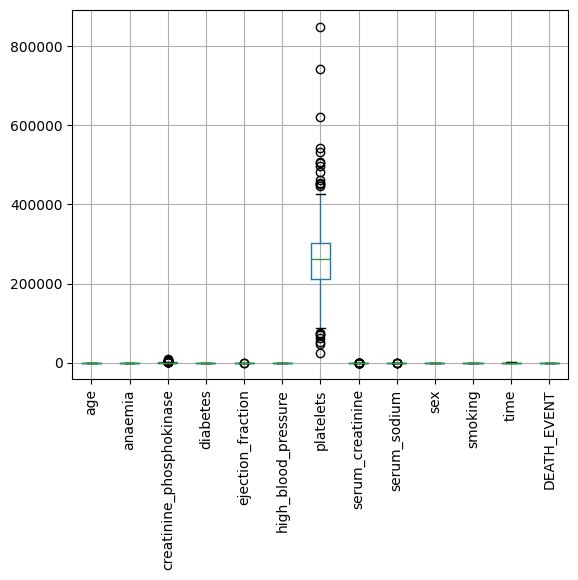

In [7]:
# Checking for outliers
df.boxplot()
plt.xticks(rotation=90)
plt.show()

In [11]:
# Handing outliers
outlier_colms = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
df1 = df.copy()

def handle_outliers(df, colm):
    '''Change the values of outliers to the upper and lower whisker values'''
    df[colm] = df[colm].astype(float)  # Convert to float to avoid dtype issues

    q1 = df[colm].quantile(0.25)
    q3 = df[colm].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df[colm] = df[colm].clip(lower=lower_bound, upper=upper_bound)
    return df

df1 = df.copy()
for colm in outlier_colms:
    df1 = handle_outliers(df1, colm)

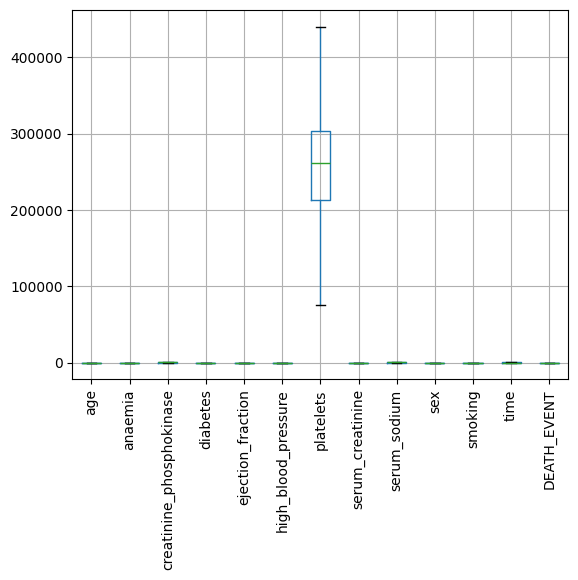

In [12]:
# Recheck for outliers
df1.boxplot()
plt.xticks(rotation=90)
plt.show()

### Split into training and testing set

In [13]:
# Split dataset into training and testing set, considering all features for prediction

X = df1.iloc[:, :-1].values
y = df1['DEATH_EVENT'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state= 123)

In [14]:
X_train[1]

array([6.50e+01, 0.00e+00, 3.95e+02, 1.00e+00, 2.50e+01, 0.00e+00,
       2.65e+05, 1.20e+00, 1.36e+02, 1.00e+00, 1.00e+00, 1.54e+02])

### Model Training

In [15]:
xgb_clf = XGBClassifier(n_estimators=200, max_depth=4, max_leaves=5, random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Model Performance

In [16]:
# Accuracy

train_acc = accuracy_score(y_train, xgb_clf.predict(X_train))
test_acc = accuracy_score(y_test, xgb_clf.predict(X_test))
print("Training accuracy: ", train_acc)
print("Testing accuracy: ", test_acc)

Training accuracy:  1.0
Testing accuracy:  0.8444444444444444


In [17]:
# F1-score

train_f1 = f1_score(y_train, xgb_clf.predict(X_train))
test_f1 = f1_score(y_test, xgb_clf.predict(X_test))
print("Training F1 score: ", train_f1)
print("Testing F1 score: ", test_f1)

Training F1 score:  1.0
Testing F1 score:  0.7307692307692307


### Save the trained model

In [18]:
# Prepare versioned save file name
save_file_name = "xgboost-model.pkl"

joblib.dump(xgb_clf, save_file_name)

['xgboost-model.pkl']

## Gradio Implementation

In [19]:
!pip -q install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [20]:
import gradio
import joblib
import numpy as np

In [21]:
# Load your trained model

import joblib

model = joblib.load('xgboost-model.pkl')  # or use pickle.load()

In [24]:
# Function for prediction

def predict_death_event(age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction,
                        high_blood_pressure, platelets, serum_creatinine, serum_sodium,
                        sex, smoking, time):

    # Create input DataFrame with correct column order
    input_data = pd.DataFrame([{
        'age': age,
        'anaemia': anaemia,
        'creatinine_phosphokinase': creatinine_phosphokinase,
        'diabetes': diabetes,
        'ejection_fraction': ejection_fraction,
        'high_blood_pressure': high_blood_pressure,
        'platelets': platelets,
        'serum_creatinine': serum_creatinine,
        'serum_sodium': serum_sodium,
        'sex': sex,
        'smoking': smoking,
        'time': time
    }])

    prediction = model.predict(input_data)[0]
    result = "YES – Death event likely." if prediction == 1 else "NO – Death event not likely."
    return result

For categorical user input, user [Radio](https://www.gradio.app/docs/radio) button component.

For numerical user input, user [Slider](https://www.gradio.app/docs/slider) component.

In [22]:
# Description summary of the dataset
import pandas as pd

# Load your dataset
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")  # Replace with your actual filename

# Display a statistical summary of numerical columns
summary = df.describe()

# Optional: Display basic info about column types and missing values
info = df.info()

# Show the summary
print("📊 Descriptive Statistics:\n")
print(summary)

print("\n📌 Column Info:\n")
print(info)

#Hint: describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
📊 Descriptive Stat

In [23]:
# Inputs from user
import pandas as pd
import joblib

# Load trained model
model = joblib.load("xgboost-model.pkl")

# --- Inputs from user ---
age = float(input("Enter age: "))
anaemia = int(input("Anaemia (0 = No, 1 = Yes): "))
creatinine_phosphokinase = float(input("Creatinine Phosphokinase: "))
diabetes = int(input("Diabetes (0 = No, 1 = Yes): "))
ejection_fraction = float(input("Ejection Fraction: "))
high_blood_pressure = int(input("High Blood Pressure (0 = No, 1 = Yes): "))
platelets = float(input("Platelets: "))
serum_creatinine = float(input("Serum Creatinine: "))
serum_sodium = float(input("Serum Sodium: "))
sex = int(input("Sex (0 = Female, 1 = Male): "))
smoking = int(input("Smoking (0 = No, 1 = Yes): "))
time = int(input("Time (Follow-up duration in days): "))

# --- Build input DataFrame ---
input_data = pd.DataFrame([{
    'age': age,
    'anaemia': anaemia,
    'creatinine_phosphokinase': creatinine_phosphokinase,
    'diabetes': diabetes,
    'ejection_fraction': ejection_fraction,
    'high_blood_pressure': high_blood_pressure,
    'platelets': platelets,
    'serum_creatinine': serum_creatinine,
    'serum_sodium': serum_sodium,
    'sex': sex,
    'smoking': smoking,
    'time': time
}])

# Output response
prediction = model.predict(input_data)[0]
response = "YES, death event is predicted." if prediction == 1 else "NO, death event is not predicted."
print(f"\n🔍 Prediction result: {response}")

Enter age: 60
Anaemia (0 = No, 1 = Yes): 0
Creatinine Phosphokinase: 250
Diabetes (0 = No, 1 = Yes): 1
Ejection Fraction: 38
High Blood Pressure (0 = No, 1 = Yes): 0
Platelets: 250000
Serum Creatinine: 1.2
Serum Sodium: 137
Sex (0 = Female, 1 = Male): 1
Smoking (0 = No, 1 = Yes): 0
Time (Follow-up duration in days): 130

🔍 Prediction result: NO, death event is not predicted.


In [26]:
# Gradio interface to generate UI link
import gradio as gr

# Title & description
title = "Patient Survival Prediction"
description = "Predict survival of a patient with heart failure, given their clinical record."

# Gradio interface
iface = gr.Interface(
    fn=predict_death_event,
    inputs=[
        gr.Number(label="Age"),
        gr.Radio([0, 1], label="Anaemia (0 = No, 1 = Yes)"),
        gr.Number(label="Creatinine Phosphokinase"),
        gr.Radio([0, 1], label="Diabetes (0 = No, 1 = Yes)"),
        gr.Number(label="Ejection Fraction"),
        gr.Radio([0, 1], label="High Blood Pressure (0 = No, 1 = Yes)"),
        gr.Number(label="Platelets"),
        gr.Number(label="Serum Creatinine"),
        gr.Number(label="Serum Sodium"),
        gr.Radio([0, 1], label="Sex (0 = Female, 1 = Male)"),
        gr.Radio([0, 1], label="Smoking (0 = No, 1 = Yes)"),
        gr.Number(label="Time (Follow-up in days)")
    ],
    outputs=gr.Text(label="Prediction"),
    title=title,
    description=description,
    allow_flagging='never'
)

# Launch with public link
iface.launch(share=True) # server_name="0.0.0.0", server_port = 8001   # Ref: https://www.gradio.app/docs/interface

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://277d8cb7eb644b4968.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
